]

## Abnormal Heartbeat Classification  

Given *ECG data about patients' hearts*, let's try to detect **abnormal heartbeats** in the data.

We will use a TensorFlow RNN to make our predictions. 

# Getting Started

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import keras
from keras.layers import Dense, LSTM, \
    Flatten, TimeDistributed, Conv2D, Dropout
from keras import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
dfs = [pd.read_csv('../input/heartbeat/mitbih_' + x + '.csv') for x in ['train', 'test']]

In [3]:
for df in dfs:
    df.columns = list(range(len(df.columns)))

In [4]:
data = pd.concat(dfs, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

data = data.rename({187: 'Label'}, axis=1)

In [5]:
data

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,Label
0,0.993311,1.000000,0.508361,0.093645,0.080268,0.160535,0.137124,0.127090,0.103679,0.127090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.948310,1.000000,0.604374,0.129225,0.035785,0.073559,0.079523,0.079523,0.079523,0.065606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.822222,0.602778,0.372222,0.225000,0.111111,0.052778,0.030556,0.002778,0.002778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.877235,0.419547,0.000000,0.191895,0.233611,0.164482,0.154946,0.169249,0.165673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.814714,0.539510,0.433242,0.258856,0.155313,0.070845,0.046322,0.024523,0.040872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109439,1.000000,0.645533,0.092219,0.135447,0.138329,0.144092,0.135447,0.132565,0.135447,0.135447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109440,0.985276,0.925153,0.825767,0.727607,0.487117,0.203681,0.024540,0.011043,0.015951,0.039264,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109441,0.964111,0.913540,0.326264,0.000000,0.216966,0.332790,0.313214,0.288744,0.288744,0.300163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109442,0.000000,0.036667,0.156667,0.241667,0.316667,0.371667,0.390000,0.425000,0.493333,0.553333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [7]:
data["Label"].unique()

array([0., 2., 4., 3., 1.])

In [8]:
len(data[data['Label']==1]),len(data[data['Label']==2]),len(data[data['Label']==3]),len(data[data['Label']==4]),len(data[data['Label']==0])

(2779, 7236, 803, 8039, 90587)

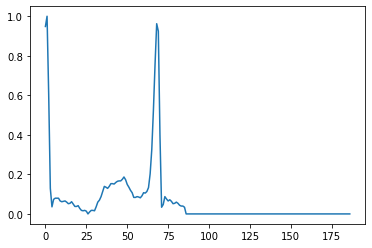

In [11]:
import matplotlib.pyplot as plt
plt.plot(data.iloc[1,:-1])

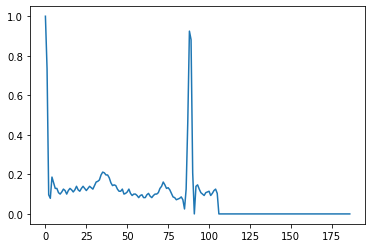

In [13]:
plt.plot(data.iloc[3499,:-1])

# Preprocessing

In [9]:
y = data['Label'].copy()
X = data.drop('Label', axis=1).copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

In [10]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [11]:
len(X_train),len(X_test),len(X_val)   

(76610, 16417, 16417)

# Training

In [12]:
X_train=X_train.values
X_test=X_test.values
X_val=X_val.values

In [13]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [14]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
X_val = X_val.reshape(len(X_val), X_val.shape[1],1)

In [15]:
len(X_train),len(X_test),len(X_val)

(316800, 16417, 16417)

In [16]:
y_test

44736     0.0
103211    0.0
70509     0.0
96485     4.0
101155    0.0
         ... 
72392     0.0
1304      0.0
98068     0.0
102350    2.0
51815     2.0
Name: Label, Length: 16417, dtype: float64

In [17]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val = to_categorical(y_val)

In [18]:
y_val

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [19]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(256, (5), activation='relu', input_shape=im_shape)(inputs_cnn)
#     conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(128, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=20,callbacks=callbacks, batch_size=516,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    print(model.summary())
    return(model,history)

In [20]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    plt.figure(figsize=(8,6))
    plt.imshow(cnf_matrix, cmap="Oranges")
    plt.colorbar()
    classes=['N', 'S', 'V', 'F', 'Q']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.show()


In [21]:


model,history=network(X_train,y_train,X_val,y_val)

Epoch 1/20
614/614 [==============================] - 13s 20ms/step - loss: 0.1376 - accuracy: 0.9527 - val_loss: 1.4696 - val_accuracy: 0.4691
Epoch 2/20
614/614 [==============================] - 12s 20ms/step - loss: 0.0394 - accuracy: 0.9870 - val_loss: 0.1323 - val_accuracy: 0.9650
Epoch 3/20
614/614 [==============================] - 12s 20ms/step - loss: 0.0244 - accuracy: 0.9920 - val_loss: 0.1431 - val_accuracy: 0.9591
Epoch 4/20
614/614 [==============================] - 12s 20ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.1305 - val_accuracy: 0.9730
Epoch 5/20
614/614 [==============================] - 12s 20ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 0.2807 - val_accuracy: 0.9345
Epoch 6/20
614/614 [==============================] - 12s 20ms/step - loss: 0.0127 - accuracy: 0.9959 - val_loss: 0.1193 - val_accuracy: 0.9793
Epoch 7/20
614/614 [==============================] - 12s 20ms/step - loss: 0.0123 - accuracy: 0.9959 - val_loss: 0.1517 - val_accuracy:

Accuracy: 98.22%


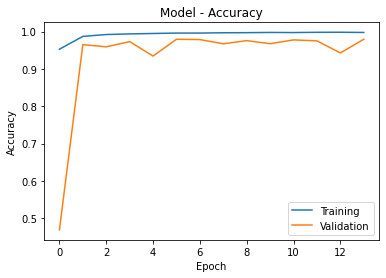

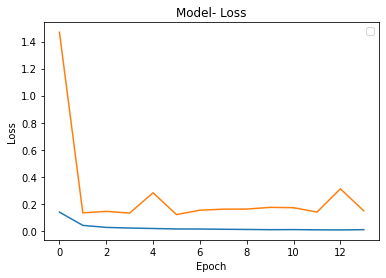

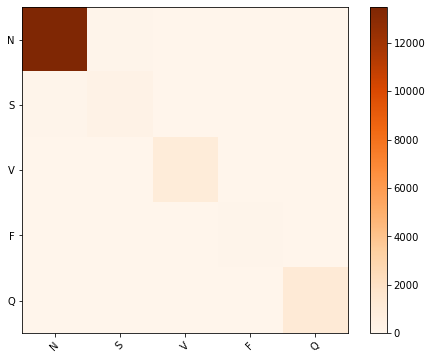

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Normalized confusion matrix


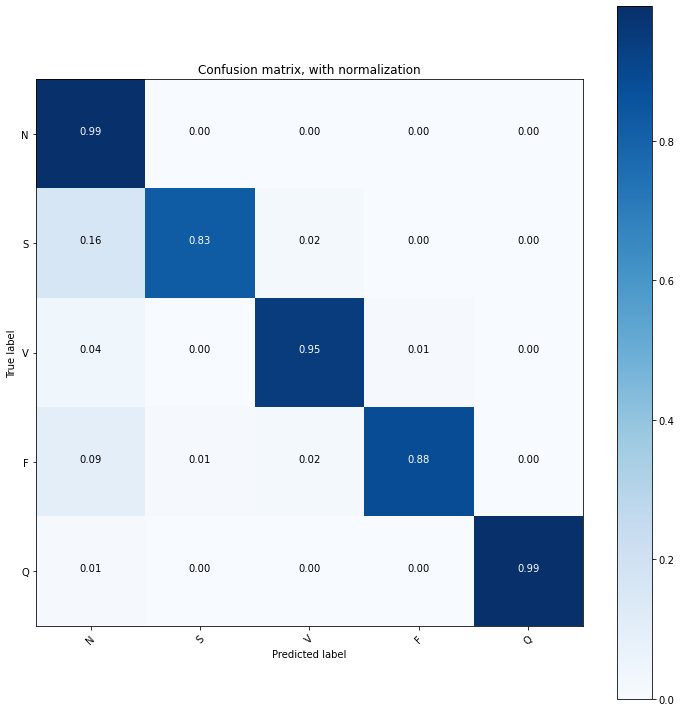

In [61]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_pred=model.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [62]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))))

print('Micro Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=['N', 'S', 'V', 'F', 'Q']))

Confusion Matrix

[[13517    34    25    32    11]
 [   61   317     6     0     0]
 [   41     4  1025    12     2]
 [   12     1     2   113     0]
 [   13     0     1     0  1188]]

Accuracy: 0.98

Micro Precision: 0.98
Micro Recall: 0.98
Micro F1-score: 0.98

Macro Precision: 0.91
Macro Recall: 0.93
Macro F1-score: 0.92

Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98

Classification Report

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     13619
           S       0.89      0.83      0.86       384
           V       0.97      0.95      0.96      1084
           F       0.72      0.88      0.79       128
           Q       0.99      0.99      0.99      1202

    accuracy                           0.98     16417
   macro avg       0.91      0.93      0.92     16417
weighted avg       0.98      0.98      0.98     16417



In [73]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(256, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(128, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(128, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    conv4_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool3)
    conv4_1=BatchNormalization()(conv4_1)
    pool4=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv4_1)
    flatten=Flatten()(pool4)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=64,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [74]:
model,history=network(X_train,y_train,X_val,y_val)

Epoch 1/40
4950/4950 [==============================] - 36s 7ms/step - loss: 0.0993 - accuracy: 0.9654 - val_loss: 0.1403 - val_accuracy: 0.9583
Epoch 2/40
4950/4950 [==============================] - 35s 7ms/step - loss: 0.0369 - accuracy: 0.9876 - val_loss: 0.0966 - val_accuracy: 0.9756
Epoch 3/40
4950/4950 [==============================] - 35s 7ms/step - loss: 0.0248 - accuracy: 0.9919 - val_loss: 0.1058 - val_accuracy: 0.9772
Epoch 4/40
4950/4950 [==============================] - 35s 7ms/step - loss: 0.0189 - accuracy: 0.9939 - val_loss: 0.1032 - val_accuracy: 0.9786
Epoch 5/40
4950/4950 [==============================] - 35s 7ms/step - loss: 0.0149 - accuracy: 0.9954 - val_loss: 0.1309 - val_accuracy: 0.9734
Epoch 6/40
4950/4950 [==============================] - 35s 7ms/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.1048 - val_accuracy: 0.9809
Epoch 7/40
4950/4950 [==============================] - 35s 7ms/step - loss: 0.0108 - accuracy: 0.9966 - val_loss: 0.1145 - val_ac

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

NameError: name 'evaluate_model' is not defined

In [69]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))))

print('Micro Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=['N', 'S', 'V', 'F', 'Q']))

Confusion Matrix

[[13503    37    37    30    12]
 [   73   303     8     0     0]
 [   27     3  1042     9     3]
 [   10     1     8   109     0]
 [    7     0     2     0  1193]]

Accuracy: 0.98

Micro Precision: 0.98
Micro Recall: 0.98
Micro F1-score: 0.98

Macro Precision: 0.91
Macro Recall: 0.92
Macro F1-score: 0.91

Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98

Classification Report

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     13619
           S       0.88      0.79      0.83       384
           V       0.95      0.96      0.96      1084
           F       0.74      0.85      0.79       128
           Q       0.99      0.99      0.99      1202

    accuracy                           0.98     16417
   macro avg       0.91      0.92      0.91     16417
weighted avg       0.98      0.98      0.98     16417



In [77]:
# from sklearn.metrics import precision_recall_fscore_support
# res = []
# # for l in ['N', 'S', 'V', 'F', 'Q']:
# #     prec,recall,_,_ = precision_recall_fscore_support(y_test.argmax(axis=1)==l,
# #                                                       y_pred.argmax(axis=1)==l
# #                                                      )
# #     res.append([l,recall[0],recall[1]])
# precision_recall_fscore_support(y_test.argmax(axis=1)=='N',
#                                                       y_pred.argmax(axis=1)=='N'
#                                                      )

In [88]:
from tensorflow.keras.layers import Bidirectional

In [38]:
def network(X_train,y_train,X_test,y_test,num_units=128):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=tf.keras.Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
#     conv3_1=BatchNormalization()(conv3_1)
    shape = conv3_1.get_shape().as_list()
    data_input_embed = tf.reshape(conv3_1, (-1, 10, shape[1] * shape[2]))
    with tf.variable_scope("encoding") as encoding_scope:
        if not bidirectional:

            # Regular approach with LSTM units
            lstm_enc = tf.contrib.rnn.LSTMCell(num_units)
            _, last_state = tf.nn.dynamic_rnn(lstm_enc, inputs=data_input_embed, dtype=tf.float32)

        else:

            # Using a bidirectional LSTM architecture instead
            enc_fw_cell = tf.contrib.rnn.LSTMCell(num_units)
            enc_bw_cell = tf.contrib.rnn.LSTMCell(num_units)

            ((enc_fw_out, enc_bw_out), (enc_fw_final, enc_bw_final)) = tf.nn.bidirectional_dynamic_rnn(
                cell_fw=enc_fw_cell,
                cell_bw=enc_bw_cell,
                inputs=data_input_embed,
                dtype=tf.float32)
            enc_fin_c = tf.concat((enc_fw_final.c, enc_bw_final.c), 1)
            enc_fin_h = tf.concat((enc_fw_final.h, enc_bw_final.h), 1)
            last_state = tf.contrib.rnn.LSTMStateTuple(c=enc_fin_c, h=enc_fin_h)

#     with tf.variable_scope("decoding") as decoding_scope:
#         if not bidirectional:
#             lstm_dec = tf.contrib.rnn.LSTMCell(num_units)
#         else:
#             lstm_dec = tf.contrib.rnn.LSTMCell(2 * num_units)

        dec_outputs, _ = tf.nn.dynamic_rnn(lstm_dec, inputs=data_output_embed, initial_state=last_state)

    logits = tf.layers.dense(dec_outputs, units=10, use_bias=True)
    
    
#     pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
#     flatten=Flatten()(pool3)
#     dense_end1 = Dense(64, activation='relu')(flatten)
#     dense_end2 = Dense(32, activation='relu')(dense_end1)
#     main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=logits)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [39]:
network(X_train,y_train,X_test,y_test,num_units=128)

AttributeError: module 'tensorflow' has no attribute 'variable_scope'

In [46]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(256, (5), activation='relu', input_shape=im_shape)(inputs_cnn)
#     conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(128, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    gru = tf.keras.layers.GRU(64, return_sequences=True)(pool3)
    gru2 = tf.keras.layers.GRU(32, return_sequences=True)(gru)
#     gru3 = tf.keras.layers.GRU(32, return_sequences=True)(gru2)
    flatten = tf.keras.layers.Flatten()(gru2)
    dense_end1 = Dense(32, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=20,callbacks=callbacks, batch_size=512,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    print(model.summary())
    return(model,history)

In [47]:


model,history=network(X_train,y_train,X_val,y_val)

Epoch 1/20
619/619 [==============================] - 15s 25ms/step - loss: 0.1948 - accuracy: 0.9327 - val_loss: 2.4296 - val_accuracy: 0.2990
Epoch 2/20
619/619 [==============================] - 15s 24ms/step - loss: 0.0554 - accuracy: 0.9815 - val_loss: 0.4963 - val_accuracy: 0.9237
Epoch 3/20
619/619 [==============================] - 15s 24ms/step - loss: 0.0355 - accuracy: 0.9883 - val_loss: 0.1137 - val_accuracy: 0.9663
Epoch 4/20
619/619 [==============================] - 15s 24ms/step - loss: 0.0252 - accuracy: 0.9917 - val_loss: 0.1018 - val_accuracy: 0.9737
Epoch 5/20
619/619 [==============================] - 15s 24ms/step - loss: 0.0195 - accuracy: 0.9938 - val_loss: 0.0907 - val_accuracy: 0.9766
Epoch 6/20
619/619 [==============================] - 15s 24ms/step - loss: 0.0165 - accuracy: 0.9946 - val_loss: 0.1021 - val_accuracy: 0.9750
Epoch 7/20
619/619 [==============================] - 15s 24ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.1214 - val_accuracy:

In [1]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

NameError: name 'evaluate_model' is not defined

In [95]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))
expand = tf.expand_dims(inputs, axis=2)
gru = tf.keras.layers.GRU(256, return_sequences=True)(expand)
gru2 = tf.keras.layers.GRU(128, return_sequences=True)(expand)
flatten = tf.keras.layers.Flatten()(gru2)
dense_end1 = Dense(64, activation='relu')(flatten)
dense_end2 = Dense(32, activation='relu')(dense_end1)
outputs = tf.keras.layers.Dense(5, activation='sigmoid')(dense_end2)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 187)]             0         
_________________________________________________________________
tf_op_layer_ExpandDims_5 (Te [(None, 187, 1)]          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 187, 128)          50304     
_________________________________________________________________
flatten_12 (Flatten)         (None, 23936)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                1531968   
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 5)               

Accuracy: 97.92%


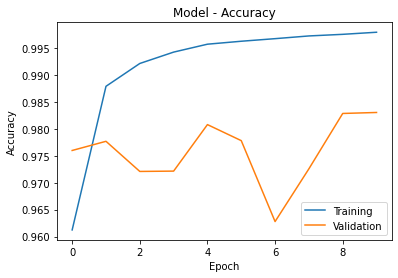

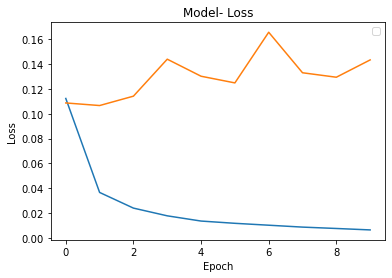

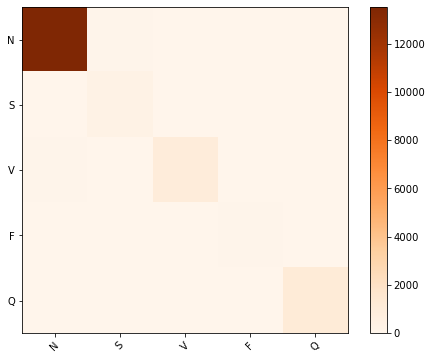

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Normalized confusion matrix


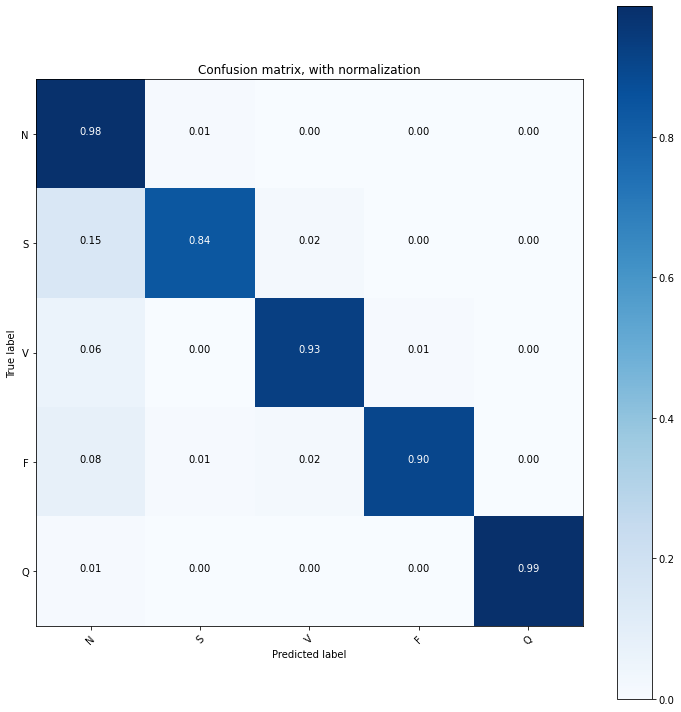

In [118]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_pred=model.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [110]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))))

print('Micro Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=['N', 'S', 'V', 'F', 'Q']))

Confusion Matrix

[[13500    59    29    21    10]
 [   44   331     9     0     0]
 [   37     3  1033    11     0]
 [   13     1     5   109     0]
 [   20     0     3     0  1179]]

Accuracy: 0.98

Micro Precision: 0.98
Micro Recall: 0.98
Micro F1-score: 0.98

Macro Precision: 0.91
Macro Recall: 0.93
Macro F1-score: 0.92

Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98

Classification Report

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     13619
           S       0.84      0.86      0.85       384
           V       0.96      0.95      0.96      1084
           F       0.77      0.85      0.81       128
           Q       0.99      0.98      0.99      1202

    accuracy                           0.98     16417
   macro avg       0.91      0.93      0.92     16417
weighted avg       0.98      0.98      0.98     16417



In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Dropout, LSTM


In [25]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))
model = Sequential()
model.add(LSTM(187,input_shape=inputs,activation="relu",return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(187,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(32,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(10,activation="softmax"))

print(model.summary())

TypeError: Cannot iterate over a tensor with unknown first dimension.

In [26]:
opt = tf.keras.optimizers.Adam(lr =1e-3,decay = 1e-5)
model.compile(loss = "sparse_categorical_crossentropy",optimizer = opt,metrics = "accuracy")
model.fit(X_train,y_train,epochs = 10,validation_data =(X_val,y_val))

Epoch 1/10


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1567 sparse_categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4783 sparse_categorical_crossentropy
        labels=target, logits=output)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:4175 sparse_softmax_cross_entropy_with_logits_v2
        labels=labels, logits=logits, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:4090 sparse_softmax_cross_entropy_with_logits
        logits.get_shape()))

    ValueError: Shape mismatch: The shape of labels (received (320,)) should equal the shape of logits except for the last dimension (received (5984, 1)).


In [27]:
input_layer = Input(shape=(10, 187))
conv1 = Conv1D(filters=32,
               kernel_size=8,
               strides=1,
               activation='relu')(input_layer)
pool1 = MaxPooling1D(pool_size=4)(conv1)
lstm1 = LSTM(32)(pool1)
output_layer = Dense(1, activation='sigmoid')(lstm1)

NameError: name 'Input' is not defined

# Results

In [ ]:
results = model.evaluate(X_val, y_val, verbose=0)

In [ ]:
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("     Test AUC: {:.4f}".format(results[2]))

In [ ]:
n_signals = 1 #So far each instance is one signal. We will diversify them in next step
n_outputs = 5 #Binary Classification

In [28]:
X_train = X_train[:(X_train.shape[0]/10)*10,:]
y_train = y_train[:(X_train.shape[0]/10)*10]

X_train = np.reshape(X_train,[-1,X_test.shape[1],X_test.shape[2]])
y_train = np.reshape(y_train,[-1,y_test.shape[1]-1,])

TypeError: slice indices must be integers or None or have an __index__ method

In [29]:
#Build the model
verbose, epochs, batch_size = True, 15, 16
n_steps, n_length = 40, 10
X_train = X_train.reshape((X_train.shape[0], 7661, n_length, n_signals))
# define model


NameError: name 'n_signals' is not defined

In [ ]:
model = Sequential()
model.add()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

In [2]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1 = TimeDistributed(Convolution1D(256, (5), activation='relu', input_shape=im_shape)(inputs_cnn))
    pool1 =TimeDistributed(MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1))
    conv2_1=TimeDistributed(Convolution1D(128, (3), activation='relu', input_shape=im_shape)(pool1))
    conv2_1=TimeDistributed(BatchNormalization()(conv2_1))
    pool2 =TimeDistributed(MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1))
    conv3_1=TimeDistributed(Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2))
    conv3_1=TimeDistributed(BatchNormalization()(conv3_1))
    pool3=TimeDistributed(MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1))
    flatten=TimeDistributed(Flatten()(pool3))
    lstm1 = LSTM(100)(flatten)
    dense_end1 = Dense(64, activation='relu')(lstm1)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    print(model.summary())
    return(model,history)

In [58]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    plt.figure(figsize=(8,6))
    plt.imshow(cnf_matrix, cmap="Oranges")
    plt.colorbar()
    classes=['N', 'S', 'V', 'F', 'Q']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.show()


model,history=network(X_train,y_train,X_val,y_val)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

ValueError: Please initialize `TimeDistributed` layer with a `tf.keras.layers.Layer` instance. You passed: Tensor("conv1d_9/Relu:0", shape=(None, 183, 256), dtype=float32)

In [ ]:
from skimage.transform import resize
import pywt
def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):
    n_samples = X.shape[0] 
    n_signals = X.shape[2] 
    
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1) 
    
    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size, n_signals), dtype = 'float32')
    
    for sample in range(n_samples):
        if sample % 1000 == 0:
            print(sample)
        for signal in range(n_signals):
            serie = X[sample, :, signal]
            # continuous wavelet transform 
            coeffs, freqs = pywt.cwt(serie, scales, wavelet_name)
            # resize the 2D cwt coeffs
            rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')
            X_cwt[sample,:,:,signal] = rescale_coeffs
            
    return X_cwt
  
# amount of pixels in X and Y 
rescale_size = 64
# determine the max scale size
n_scales = 64

X_train_cwt = create_cwt_images(X_train, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_train_cwt.shape}")
X_test_cwt = create_cwt_images(X_test, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_test_cwt.shape}")
X_val_cwt = create_cwt_images(X_val, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_val_cwt.shape}")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


# Data Every Day  

This notebook is featured on Data Every Day, a YouTube series where I train models on a new dataset each day.  

***

Check it out!  
https://youtu.be/MfFe6FbWNSw